In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pickle

In [5]:
df = pd.read_csv("loan_prediction.csv")
df.shape

(614, 13)

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

There are null values in Gender, married, Dependents, Self_employed, LoanAmount, Loan_Amount_Term, and Credit_History. We can remove these or we can fill appropriately.

In [7]:
# filling the missing values with mode
df = df.fillna(df.mode().loc[0])
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [8]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

## Exploratory Data Analysis

In [10]:
# filtering the categorical variables
columns = list(df.columns)
cat_feat = []
for column in df.columns:
    if df[column].dtypes == 'object':
        cat_feat.append(column)
cat_feat

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

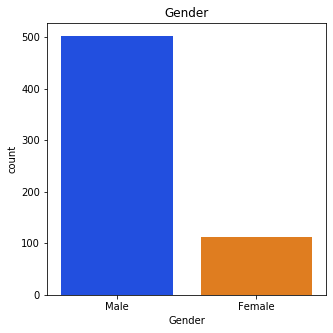

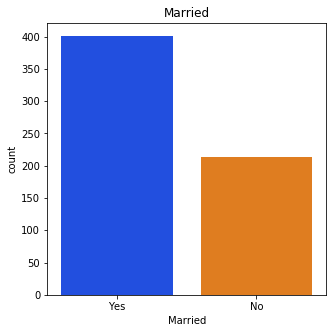

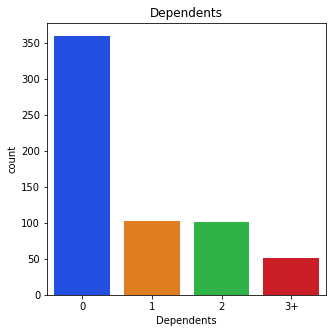

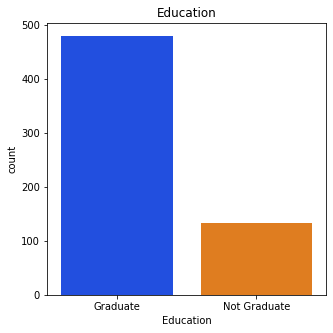

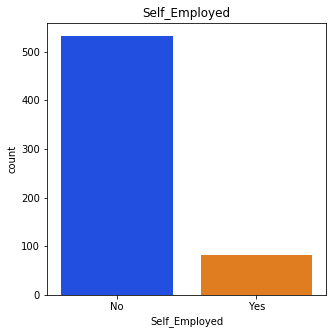

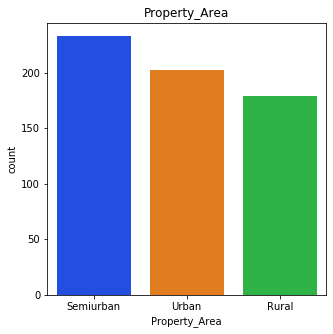

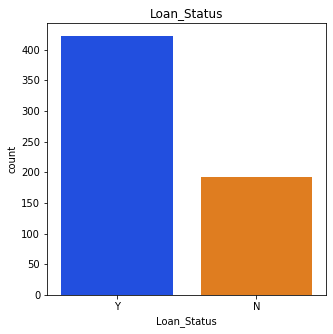

In [14]:

for feat in cat_feat:
    if feat == "Loan_ID":
        pass
    else:
        count = df[feat].value_counts()
        plt.figure(figsize=(5, 5))
        sns.barplot(count.index, count.values, palette='bright')
        plt.title(feat)
        plt.xlabel(feat)
        plt.ylabel("count")
        plt.tick_params(labelsize=10)
        plt.show()

Analysis: Most of the applicant are male, and most of them are married. Almost half of the applicants have 0 dependents.nearly 80% of the applicants are graduated and self employed at the same time. All the applicants are almost equally distributed in semi urban, urban and rural areas. Nearly 80% of the loans are approved.

We have class imbalance in the case. We will use ove sampling technique to balance the classes.

## handling the categorical variables

In [20]:
from sklearn.preprocessing import LabelEncoder
for column in cat_feat:
    if column == "Loan_ID":
        pass
    else:
        encoder = LabelEncoder()
        df[column] = encoder.fit_transform(df[column])

## Handling the class imbalance

In [21]:
df.Loan_Status.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [17]:
422 - 192

230

In [24]:
df1 = df[df["Loan_Status"]==0]
df2 = df[df["Loan_Status"]==1]

In [25]:
import secrets
ls = range(192)

for i in range(230):
    x = secrets.choice(ls)
    try:
        df1 = df1.append(df1.iloc[x])
    except:
        print (x)
df1.shape

(422, 13)

In [26]:
dframes = [df1, df2]
df = pd.concat(dframes)

# shuffling the data
df = shuffle(df)
df.shape

(844, 13)

### splitting the features and target variables

In [27]:
X = df.drop(['Loan_Status', "Loan_ID"], axis=1)
y = df['Loan_Status']

### Scaling the data

In [28]:
for col in X.columns:
    scaler = StandardScaler()
    X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))

## Logistic Regression

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=42)
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X_test)

In [30]:
accuracy = round(accuracy_score(y_test, y_pred_LR),3)
accuracy

0.663

Logistic regression is giving accuracy of 66%. This can be improve by ROC and AUC.

In [31]:
conf_m = confusion_matrix(y_test, y_pred_LR)
print(conf_m)

[[36 38]
 [19 76]]


In [32]:
cols = ["Thresholds",'TP', 'FP', 'TN','FN']
lst = []
for i in np.arange(0,1.1,0.1):
    y_pred = np.where(LR.predict_proba(X_test)[:,1]>i,1,0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    lst.append([round(i,1),tp,fp,tn,fn])
confusion_result_LR = pd.DataFrame(lst, columns=cols)

In [33]:
def calculate_metrics(results):
    roc = pd.DataFrame(index = results['Thresholds'], columns=['recall', 'precision', 'f1', 'tpr', 'fpr'])
    
    for i in results.iterrows():
        
        t, tp, fp,tn, fn = i[1]
        
        recall = tp / (tp + fn)
        
        if tp == fp == 0:
            precision = 0
            true_positive_rate = 0
        
        else:
            precision = tp / (tp + fp)
            true_positive_rate = tp / (tp + fn)
            
        if precision == recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        
        
        false_positive_rate = fp / (fp + tn)
        
        roc.ix[t, 'recall'] = recall
        roc.ix[t, 'precision'] = precision
        roc.ix[t, 'f1'] = f1
        roc.ix[t, 'tpr'] = true_positive_rate
        roc.ix[t, 'fpr'] = false_positive_rate
    
    return roc

In [34]:
roc_LR = calculate_metrics(confusion_result_LR)
roc_LR.reset_index()

C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated

,Thresholds,recall,precision,f1,tpr,fpr
0,0.0,1,0.56213,0.719697,1,1
1,0.1,0.989474,0.671429,0.8,0.989474,0.621622
2,0.2,0.989474,0.671429,0.8,0.989474,0.621622
3,0.3,0.989474,0.676259,0.803419,0.989474,0.608108
4,0.4,0.957895,0.674074,0.791304,0.957895,0.594595
5,0.5,0.8,0.666667,0.727273,0.8,0.513514
6,0.6,0.6,0.703704,0.647727,0.6,0.324324
7,0.7,0.2,0.730769,0.31405,0.2,0.0945946
8,0.8,0,0,0,0,0
9,0.9,0,0,0,0,0


Populating the interactive namespace from numpy and matplotlib


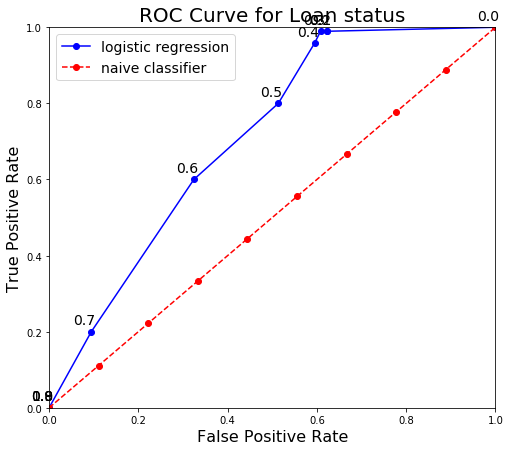

In [36]:
%pylab inline
figsize(8, 7)
plt.style.use('seaborn-dark-palette')
thresholds = [str(t) for t in confusion_result_LR['Thresholds']]
plt.plot(roc_LR['fpr'], roc_LR['tpr'], 'bo-', label = 'logistic regression');
plt.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'naive classifier');
for x, y, s in zip(roc_LR['fpr'], roc_LR['tpr'], thresholds):
    plt.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});

plt.legend(prop={'size':14})
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate', size = 16); plt.xlabel('False Positive Rate', size = 16);
plt.title('ROC Curve for Loan status', size = 20);

f-measure is maximum at the tthreshold 0.3.

In [37]:
y_pred = np.where(LR.predict_proba(X_test)[:,1]>0.3,1,0)
pd.crosstab(y_test, y_pred)

col_0,0,1
Loan_Status,,
0,29,45
1,1,94


In [39]:
y_pred = np.where(LR.predict_proba(X_test)[:,1]>0.3,1,0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN:",tn,"FP:",fp,"FN:",fn,"TP:",tp)
recall = round(tp/(tp+fn),2)
print("True positive rate:",recall)
print("False positive rate:",round(fp/(fp+tn),2))
precision = round(tp/(tp+fp),2)
print("Precision:",precision)
print("f-measure:",round(2*recall*precision/(recall+precision),2))

TN: 29 FP: 45 FN: 1 TP: 94
True positive rate: 0.99
False positive rate: 0.61
Precision: 0.68
f-measure: 0.81


## Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(random_state=42)
DT.fit(X_train, y_train)
y_pred_DT = DT.predict(X_test)

In [47]:
accuracy = round(accuracy_score(y_test, y_pred_DT),3)
accuracy

0.846

In [49]:
conf_m = confusion_matrix(y_test, y_pred_DT)
print(conf_m)

[[70  4]
 [22 73]]


In [50]:
cols = ["Thresholds",'TP', 'FP', 'TN','FN']
lst = []
for i in np.arange(0,1.1,0.1):
    y_pred = np.where(DT.predict_proba(X_test)[:,1]>i,1,0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    lst.append([round(i,1),tp,fp,tn,fn])
confusion_result_DT = pd.DataFrame(lst, columns=cols)

In [52]:
roc_DT = calculate_metrics(confusion_result_DT)
roc_DT.reset_index()

C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated

,Thresholds,recall,precision,f1,tpr,fpr
0,0.0,0.768421,0.948052,0.848837,0.768421,0.0540541
1,0.1,0.768421,0.948052,0.848837,0.768421,0.0540541
2,0.2,0.768421,0.948052,0.848837,0.768421,0.0540541
3,0.3,0.768421,0.948052,0.848837,0.768421,0.0540541
4,0.4,0.768421,0.948052,0.848837,0.768421,0.0540541
5,0.5,0.768421,0.948052,0.848837,0.768421,0.0540541
6,0.6,0.768421,0.948052,0.848837,0.768421,0.0540541
7,0.7,0.768421,0.948052,0.848837,0.768421,0.0540541
8,0.8,0.768421,0.948052,0.848837,0.768421,0.0540541
9,0.9,0.768421,0.948052,0.848837,0.768421,0.0540541


Populating the interactive namespace from numpy and matplotlib


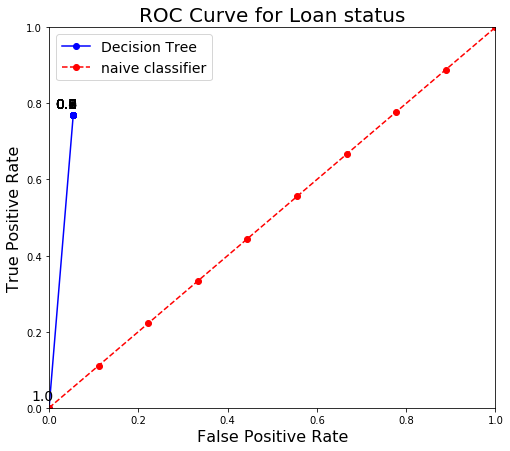

In [53]:
%pylab inline
figsize(8, 7)
plt.style.use('seaborn-dark-palette')
thresholds = [str(t) for t in confusion_result_DT['Thresholds']]
plt.plot(roc_DT['fpr'], roc_DT['tpr'], 'bo-', label = 'Decision Tree');
plt.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'naive classifier');
for x, y, s in zip(roc_DT['fpr'], roc_DT['tpr'], thresholds):
    plt.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});

plt.legend(prop={'size':14})
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate', size = 16); plt.xlabel('False Positive Rate', size = 16);
plt.title('ROC Curve for Loan status', size = 20);

## Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)
accuracy = round(accuracy_score(y_test, y_pred_RF),3)
accuracy

0.899

In [55]:
conf_m = confusion_matrix(y_test, y_pred_RF)
conf_m

array([[70,  4],
       [13, 82]], dtype=int64)

The accuracy of the random forest is much better than the decision tree and logistic regression.

In [56]:
cols = ["Thresholds",'TP', 'FP', 'TN','FN']
lst = []
for i in np.arange(0,1.1,0.1):
    y_pred = np.where(RF.predict_proba(X_test)[:,1]>i,1,0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    lst.append([round(i,1),tp,fp,tn,fn])
confusion_result_RF = pd.DataFrame(lst, columns=cols)

In [58]:
roc_RF = calculate_metrics(confusion_result_RF)
roc_RF.reset_index()

C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated

,Thresholds,recall,precision,f1,tpr,fpr
0,0.0,1,0.575758,0.730769,1,0.945946
1,0.1,0.989474,0.764228,0.862385,0.989474,0.391892
2,0.2,0.978947,0.823009,0.894231,0.978947,0.27027
3,0.3,0.936842,0.927083,0.931937,0.936842,0.0945946
4,0.4,0.926316,0.956522,0.941176,0.926316,0.0540541
5,0.5,0.863158,0.953488,0.906077,0.863158,0.0540541
6,0.6,0.747368,0.959459,0.840237,0.747368,0.0405405
7,0.7,0.610526,0.966667,0.748387,0.610526,0.027027
8,0.8,0.347368,1,0.515625,0.347368,0
9,0.9,0.0736842,1,0.137255,0.0736842,0


Populating the interactive namespace from numpy and matplotlib


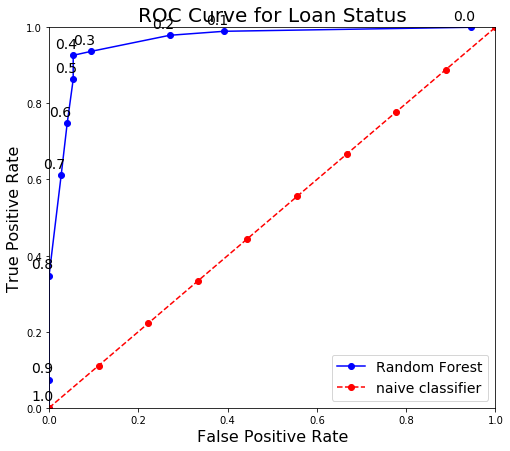

In [59]:
%pylab inline
figsize(8, 7)
plt.style.use('seaborn-dark-palette')
thresholds = [str(t) for t in confusion_result_RF['Thresholds']]
plt.plot(roc_RF['fpr'], roc_RF['tpr'], 'bo-', label = 'Random Forest');
plt.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'naive classifier');
for x, y, s in zip(roc_RF['fpr'], roc_RF['tpr'], thresholds):
    plt.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});

plt.legend(prop={'size':14})
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate', size = 16); plt.xlabel('False Positive Rate', size = 16);
plt.title('ROC Curve for Loan Status', size = 20);

F-measure is maximum at threshold 0.4.

In [61]:
y_pred = np.where(RF.predict_proba(X_test)[:,1]>0.4,1,0)
pd.crosstab(y_test, y_pred)

col_0,0,1
Loan_Status,,
0,70,4
1,7,88


In [62]:
y_pred = np.where(RF.predict_proba(X_test)[:,1]>0.3,1,0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN:",tn,"FP:",fp,"FN:",fn,"TP:",tp)
recall = round(tp/(tp+fn),2)
print("True positive rate:",recall)
print("False positive rate:",round(fp/(fp+tn),2))
precision = round(tp/(tp+fp),2)
print("Precision:",precision)
print("f-measure:",round(2*recall*precision/(recall+precision),2))

TN: 67 FP: 7 FN: 6 TP: 89
True positive rate: 0.94
False positive rate: 0.09
Precision: 0.93
f-measure: 0.93


# Naive Bayes

In [96]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, y_train)
y_pred_NB = NB.predict(X_test)
accuracy = round(accuracy_score(y_test, y_pred_NB),3)
accuracy

0.734

The accuracy of the naive bayes is 73 % which is less than the random forest. We can improve it a bit by using ROC and AUC.

In [97]:
cols = ["Thresholds",'TP', 'FP', 'TN','FN']
lst = []
for i in np.arange(0,1.1,0.1):
    y_pred = np.where(NB.predict_proba(X_test)[:,1]>i,1,0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    lst.append([round(i,1),tp,fp,tn,fn])
confusion_result_NB = pd.DataFrame(lst, columns=cols)
roc_NB = calculate_metrics(confusion_result_NB)
roc_NB.reset_index()

C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated

,Thresholds,recall,precision,f1,tpr,fpr
0,0.0,1,0.56213,0.719697,1,1
1,0.1,0.968421,0.681481,0.8,0.968421,0.581081
2,0.2,0.957895,0.679104,0.79476,0.957895,0.581081
3,0.3,0.957895,0.679104,0.79476,0.957895,0.581081
4,0.4,0.957895,0.689394,0.801762,0.957895,0.554054
5,0.5,0.947368,0.692308,0.8,0.947368,0.540541
6,0.6,0.936842,0.689922,0.794643,0.936842,0.540541
7,0.7,0.894737,0.696721,0.78341,0.894737,0.5
8,0.8,0.852632,0.704348,0.771429,0.852632,0.459459
9,0.9,0.547368,0.712329,0.619048,0.547368,0.283784


Populating the interactive namespace from numpy and matplotlib


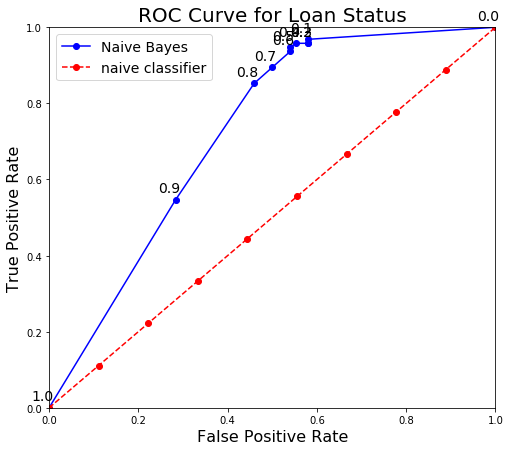

In [98]:
%pylab inline
figsize(8, 7)
plt.style.use('seaborn-dark-palette')
thresholds = [str(t) for t in confusion_result_NB['Thresholds']]
plt.plot(roc_NB['fpr'], roc_NB['tpr'], 'bo-', label = 'Naive Bayes');
plt.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'naive classifier');
for x, y, s in zip(roc_NB['fpr'], roc_NB['tpr'], thresholds):
    plt.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});

plt.legend(prop={'size':14})
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate', size = 16); plt.xlabel('False Positive Rate', size = 16);
plt.title('ROC Curve for Loan Status', size = 20);

f-measure is maximum at threshold of 0.4.

In [99]:
y_pred = np.where(NB.predict_proba(X_test)[:,1]>0.4,1,0)
pd.crosstab(y_test, y_pred)

col_0,0,1
Loan_Status,,
0,33,41
1,4,91


In [100]:
y_pred = np.where(NB.predict_proba(X_test)[:,1]>0.4,1,0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN:",tn,"FP:",fp,"FN:",fn,"TP:",tp)
recall = round(tp/(tp+fn),2)
print("True positive rate:",recall)
print("False positive rate:",round(fp/(fp+tn),2))
precision = round(tp/(tp+fp),2)
print("Precision:",precision)
print("f-measure:",round(2*recall*precision/(recall+precision),2))

TN: 33 FP: 41 FN: 4 TP: 91
True positive rate: 0.96
False positive rate: 0.55
Precision: 0.69
f-measure: 0.8


## Conclusion

The best model comes out to be random forest. We will save this model as pickle file.

In [102]:
pickle.dump(RF, open('model.pkl','wb'))